In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# VAE model
class VAE(nn.Module):
    def __init__(self, input_size=4, h_dim=10, z_dim=3):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, input_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    # 重参数
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var
model = VAE()
model

VAE(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
  (fc4): Linear(in_features=3, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=4, bias=True)
)

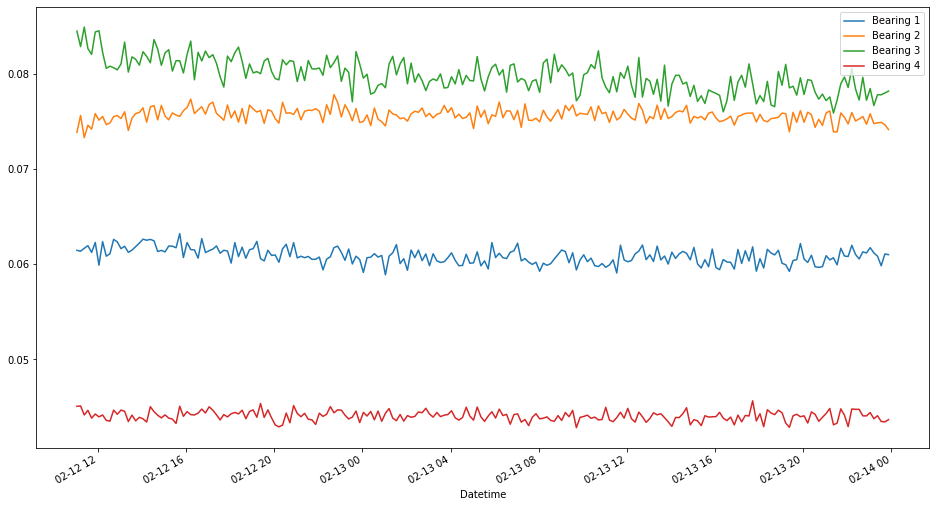

In [2]:
import numpy as np
import pandas as pd

sample_data = pd.read_csv('../data/nasa/2nd_test/2nd_test_resample_10minutes.csv', 
                          index_col='Datetime', 
                          usecols=['Datetime','Bearing 1','Bearing 2','Bearing 3','Bearing 4'])
sample_data.index = pd.to_datetime(sample_data.index, format="%Y.%m.%d.%H.%M.%S")

train = sample_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
test = sample_data['2004-02-13 23:52:39':]
train.plot(figsize=(16, 9))

In [3]:
# Normalize data
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(train),
                              columns=train.columns,
                              index=train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(test),
                             columns=test.columns,
                             index=test.index)
X_train.shape

(222, 4)

/Users/shenmengjia/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


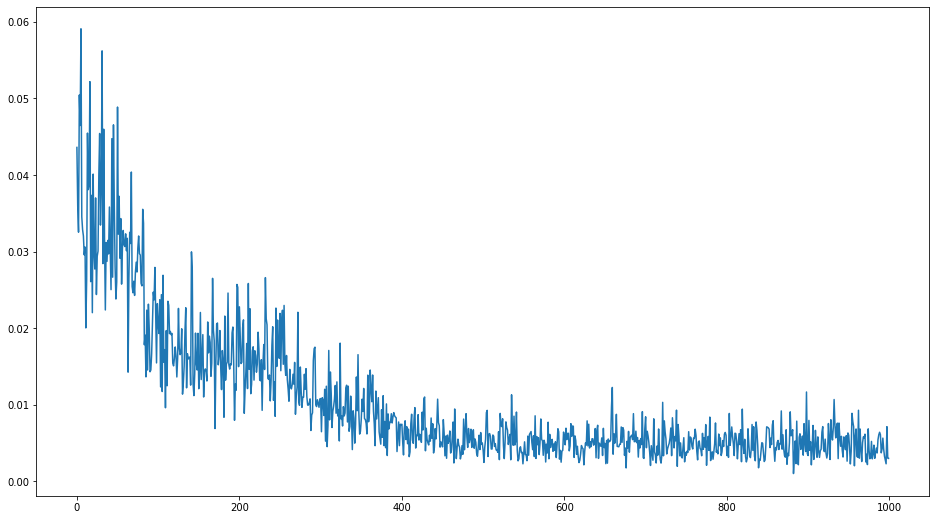

In [4]:
lr = 0.01
epoch = 1000
batch_size = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.MSELoss()
all_loss = []

for epoch in range(epoch):
    idx = np.random.choice(X_train.shape[0], size=batch_size, replace=False)
    b_x = np.array(X_train)[idx, :]
    b_x = torch.from_numpy(b_x).float()

    decoded_x, _, _ = model(b_x)

    loss = loss_func(decoded_x, b_x) 
    all_loss.append(loss.item())
    optimizer.zero_grad()          
    loss.backward()                
    optimizer.step() 

import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(np.array(range(epoch+1)), np.array(all_loss)) # loss 收敛较差；

/Users/shenmengjia/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(0.0, 0.5)

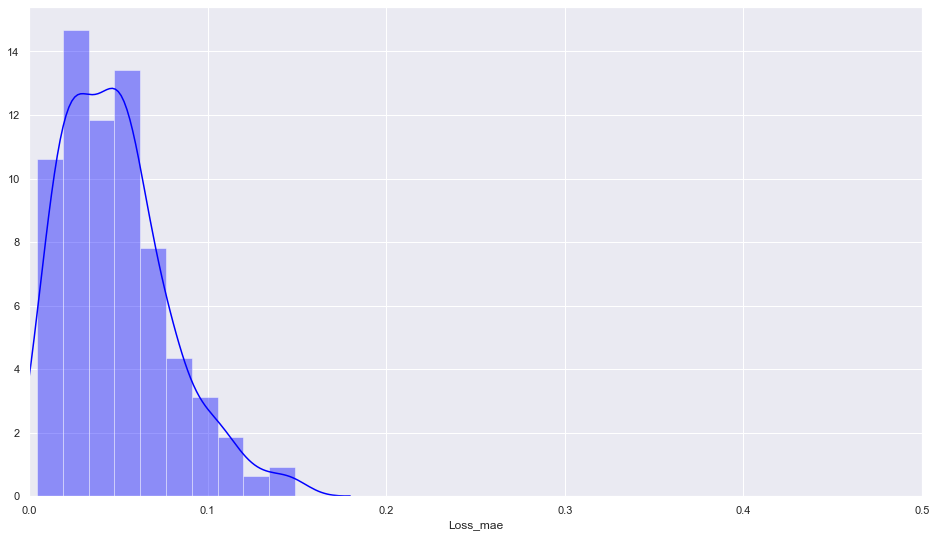

In [5]:
X_train_tensor = torch.from_numpy(np.array(X_train)).float()
X_pred, _, _ = model(X_train_tensor)

X_pred = pd.DataFrame(X_pred.detach().numpy(),
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)

import seaborn as sns
plt.figure(figsize=(16, 9))
sns.set(color_codes=True)
sns.distplot(scored['Loss_mae'],
             bins = 10,
             kde= True,
            color = 'blue')
plt.xlim([0.0,.5])

/Users/shenmengjia/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


,Loss_mae,Threshold,Anomaly
Datetime,,,
2004-02-13 23:52:39,0.111775,0.3,False
2004-02-14 00:02:39,0.074451,0.3,False
2004-02-14 00:12:39,0.004805,0.3,False
2004-02-14 00:22:39,0.027490,0.3,False
2004-02-14 00:32:39,0.040054,0.3,False


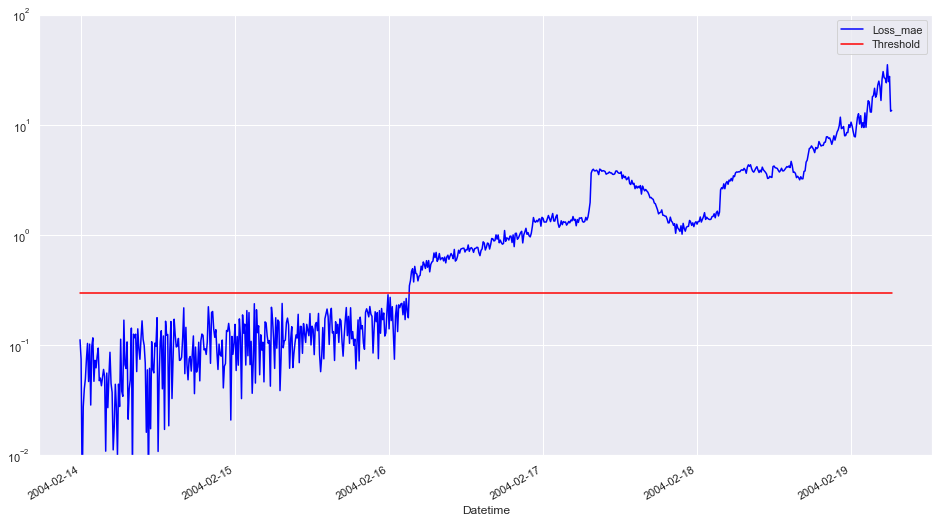

In [10]:
X_pred, _, _ = model(torch.from_numpy(np.array(X_test)).float())
X_pred = pd.DataFrame(X_pred, columns=X_test.columns)
X_pred.index = X_test.index


threshod = 0.3
scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = threshod
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
display(scored.head())

scored.plot(logy=True,  figsize = (16, 9), ylim = [1e-2,1e2], color = ['blue','red'])